# How many lines of codes do I need to observe the impact of Covid-19 on climate and pollution?

_Nitogren dioxide_ (NO2) is a generated when burning fossil fuels, most notably in internal combustion engines. While there are also a few natural processes that release NO2, its presence in the atmosphere is a clear indicator of economic and human activity. The gas has various negative environmental effects. When reacting with water molecules in the atmosphere, it causes _acid rain_, which in turn harms sensitive ecosystems in lakes and forests. It also forms _nitrate_ particulates contributing to nitrient pollution in coastal waters.

The global Covid-19 pandemic lead to an ongoing series of so-called _shutdowns_, government ordered mandates for people to stay at home as much as possible to limit further spread of the virus. These in turn led to reduced economic activity.

The aim of this notebook is to showcase the impact of these shutdowns on economic activity, as exhibited by changing NO2 content in the atmosphere. To do so, we will use measurements from the _European Space Agency's_ (ESA) _Sentinel 5_ satellites. These monitor NO2, yet also ozone, methane, formaldehyde, aerosols, carbon monoxide and SO2 gases in the earth's atmosphere. Their data can be accessed via _IBM PAIRS Geoscope_.

Note that tutorials on how to use IBM PAIRS can be found at https://pairs.res.ibm.com/tutorial.

In [1]:
import os, logging
from ibmpairs import paw
from datetime import datetime, timedelta

iso8601 = '%Y-%m-%dT%H:%M:%SZ'

logging.basicConfig(level = logging.WARNING)
pawLogger = logging.getLogger('ibmpairs.paw')
pawLogger.setLevel(logging.INFO)

To start, we import a number of python modules. The only noteworthy one here is `ibmpairs.paw`, the python wrapper for the PAIRS API. It can be installed via pip or conda. See also https://github.com/ibm/ibmpairs. For convenience we define a pattern for timestamps conforming to the ISO8601 standard. Note that we also initialize python's logging module to see log messages from the `paw` module.

### Querying the data

We want to aggregate the NO2 data over each calendar month. To do so, we define a helper function which simply returns the timestamps corresponding to the beginning and end of each month. PAIRS uses a semi-open interval when defining time ranges. That is, a time range indicated by `startTime` and `endTime` excludes the start yet includes the end. `(startTime, endTime]` in other words. The function `queryInterval` we define here respects that.

In [2]:
def queryInterval(year, month):
    startTime = datetime(year, month, 1)
    endTime = datetime(year, month, 1)
    while startTime.month == endTime.month:
        endTime += timedelta(days=1)
    startTime = startTime-timedelta(seconds=1)
    endTime = endTime-timedelta(seconds=1)
    return {'start' : startTime.strftime(iso8601), 'end' : endTime.strftime(iso8601)}

With that out of the way, we define our query for PAIRS. The data is stored in layer `50424`. (See the Data Explorer in the PAIRS GUI to obtain layer IDs.) We want to consider an almost global area bounded by -74 to 74 degrees latitude and -169 to 169 degrees longitude. Finally, we consider months February through April.

In [3]:
layerID = '50424'
queryArea= (-74, -169, 74, 169)
monthsOfInterest = range(2, 5)

queryJson = {
    'layers' : [],
    'name': 'Global NO2 history',
    'spatial' : {'type' : 'square', 'coordinates' : queryArea},  
    'temporal' : {'intervals' : [{'snapshot' : '2020-07-07T00:00:00Z'}]}
}
for month in monthsOfInterest:
    queryJson['layers'].extend([
        {
            'alias':'intNO2_2020_{:0>2}'.format(month),
            'type' : 'raster',
            'temporal': {'intervals': [queryInterval(2020, month)]},
            'id' : layerID,
            'aggregation': 'Mean',
            'output': False
        },
        {
            'alias':'NO2_2020_{:0>2}'.format(month),
            'expression' : '$intNO2_2020_{:0>2}'.format(month),
            'output': True
        }
    ])
        

We can now submit the query to PAIRS. There are various mechanisms to communicate PAIRS credentials to the `paw` library. Here, we simply hand them to the constructor of `paw.PAIRSQuery` directly.

In [4]:
query = paw.PAIRSQuery(queryJson, auth=('username', 'password'))
query.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1594699200_02646870


In [5]:
query.poll_till_finished()

### Downloading and plotting the data

Once the query is complete, we download the data to use in various downstream tasks. In the case at hand, we simply generate a plot.

In [6]:
from matplotlib import pyplot as plt

In [7]:
query.download()
query.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1594699200_02646870_20dc366db106c47d3a2f063399ca7ce3.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


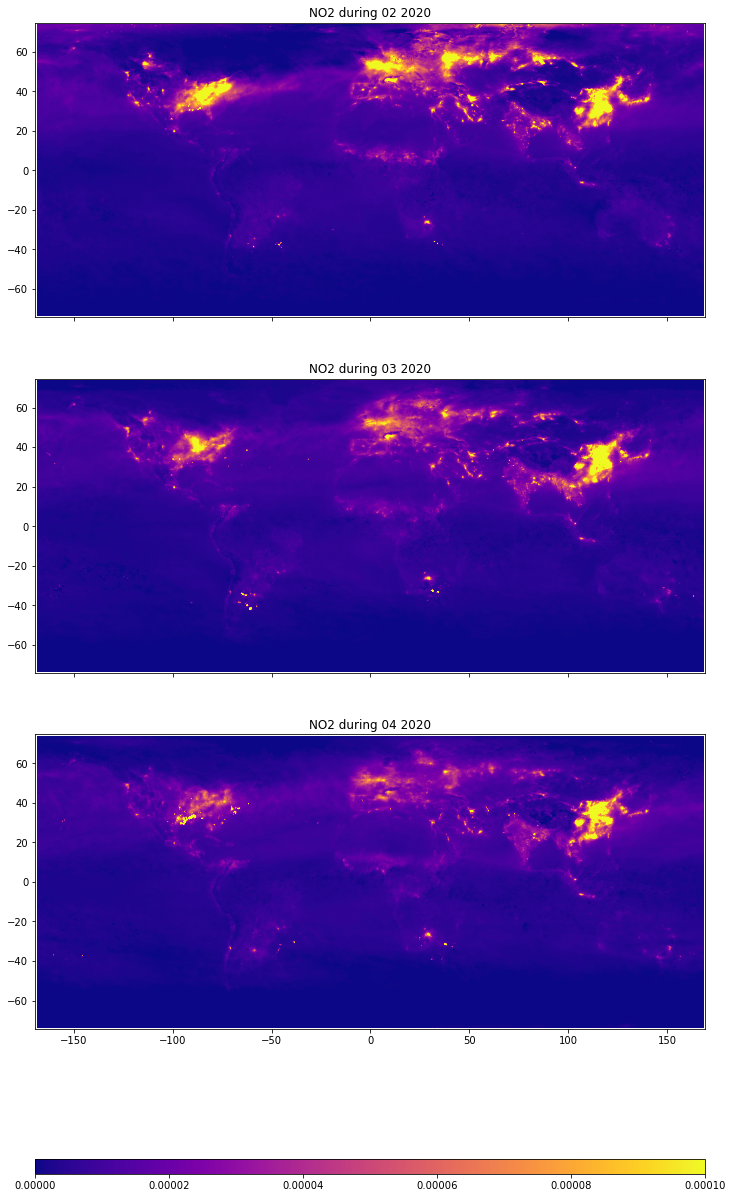

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(12, 20), sharex=True, sharey=True)
for i, m in enumerate(monthsOfInterest):
    k = 'Expression-NO2_2020_{m:0>2}[NO2_2020_{m:0>2}]-Exp'.format(m=m)
    bBox = query.metadata[k]['details']['boundingBox']
    im = ax[i].imshow(
        query.data[k],
        extent=(bBox['minLongitude'], bBox['maxLongitude'], bBox['minLatitude'], bBox['maxLatitude']),
        vmin=0, vmax=1e-4, cmap='plasma'
    )
    ax[i].set_title('NO2 during {m:0>2} 2020'.format(m=m))
fig.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.9)
axCB = fig.add_axes([0.125, 0.1, 0.9-0.125, 0.01])
fig.colorbar(im, cax=axCB, orientation='horizontal')
plt.savefig('no2.png', dpi=60, bbox_inches='tight')
plt.show()